# EN.535.610 Spring 2023 Project Code

## Authors: Chris Hennessy, Stephen Marinsek, Ryan Payne

## Import the required packages

In [1]:
#Import all required dependencies here

#These dependencies should be available by default via Anaconda install
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#These dependenies may need to be installed by the user and may not have
#come pre-installed with Anaconda
import xraydb

#Import Matplotlib and configure inline plotting
#Setting up options for plotting
%matplotlib inline
#Settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

## Define the required classes for the computation

In [2]:
#Create a class to define internal nodes
#Where x-rays will be absorbed and heat transfer will occur through conduction only
class InternalElement:
    """This class is used by the Section class (via composition design pattern) and represents an internal,
    solid element of material. These elements absorb cold x-rays and transmit heat via conduction only."""
    
    #Class constructor
    def __init__(self,  
                 t_conductivity,
                 spec_heat,
                 cs_area, 
                 ic_temp, 
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density):
        """InternalElement Class Constructor
        This function is used to enter the material properties and initial conditions for each element.
        Inputs:
            t_conductivity <float>: Thermal conductivity of the element's material
            spec_heat <float>: Specific heat of the element's material
            cs_area <float>: The cross-sectional area of the element
            ic_temp <float>: The initial condition for temperature of the element
            element_length <float>: The length of the element (colinear w/ x-ray direction)
            ablation_temp <float>: The temperature at which the material ablates
            rad_abs_coefficient <float>: The mass attenuation factor of the material
            density <float>: The density of the material
        Outputs:
            None"""
        
        #Initialize instance state
        self.absorbed_energy = 0
        self.rem_energy_flux = 0
        self.temp = ic_temp
        self.t_conductivity = t_conductivity
        self.spec_heat = spec_heat
        self.cs_area = cs_area
        self.nm1_temp = 0
        self.nm0_temp = 0
        self.is_ablated = False
        self.element_length = element_length
        self.ablation_temp = ablation_temp
        self.rad_abs_coefficient = rad_abs_coefficient
        self.density = density
        
    #Function to set the initial conditions for the element
    def set_ics(self, initial_temp):
        """This function is used to set the temperature initial condition of the element.
        Inputs:
            initial_temp <float>: The initial condition for temperature of the element
        Outputs:
            None"""
        
        self.nm1_temp = initial_temp
        
#Create a class to define the entire section of material
#The computation will be performed here
class Section:
    """This class is used to represent a cross-section of one or more materials which will absorb x-rays and undergo
    thermal changes."""
    
    eV_to_Joule = 1.602e-19
    
    #Class constructor
    def __init__(self):
        self.elements_list = []
        self.rem_elements = []
        self.has_run_rad = False
        self.has_run_ablation = False
        self.has_run_temp = False
    """InternalElement Class Constructor
        This function is used to initialize variables for a Section class instance. No inputs are required by the user
        at this step.
        Inputs:
            None
        Outputs:
            None"""
        
    #Function to add a material layer to the section
    #Materials added from foreward (x-ray incoming direction) and populates back
    def add_matl(self,
                 quantity,
                 t_conductivity,
                 spec_heat,
                 cs_area,
                 ic_temp,
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density):
        """add_matl function
        This function is used to add a new thickness of material. Call this function multiple times to add additional
        material layers. Subsequent calls will add material to the back (away from initial x-ray impingment surface)
        Inputs:
            quantity <int>: Number of elements in the section of material
            t_conductivity <float>: The material's thermal conductivity
            spec_heat <float>: The material's specific heat
            cs_area <float>: The cross sectional area for the 1D material section (normal to x-rays)
            ic_temp <float>: Initial temperature of the material
            element_length <float>: The length of each element in the material layer
            ablation_temp <float>: The temperature at which the material will ablate
            rad_abs_coefficient <float>: The mass attenuation factor of the material
            density <float>: The density of the material
        Outputs:
            None"""
        
        for i in range(0, quantity):
            new_element = InternalElement(t_conductivity,
                                          spec_heat,
                                          cs_area,
                                          ic_temp,
                                          element_length,
                                          ablation_temp,
                                          rad_abs_coefficient,
                                          density)
            self.elements_list.append(new_element)
        
    #Function to propagate x-rays through material
    def prop_xray_energy(self, tot_x_ray_energy):
        """prop_xray_energy function
        After all the layers of materials have been added, call this function to pass x-ray energy through
        the material section to calculate how much each element absorbs and the accompanying temperature change
        Inputs:
            tot_x_ray_energy <float>: Energy of all the x-rays to pass through the material's section [eV]
        Outputs:
            None"""
    
        tsprt_flux = tot_x_ray_energy
        for element in self.elements_list:
            delta_tsprt_flux = tsprt_flux * element.rad_abs_coefficient * element.density * element.element_length
            element.absorbed_energy = delta_tsprt_flux * Section.eV_to_Joule
            element.rem_energy_flux = tsprt_flux
            tsprt_flux = tsprt_flux - delta_tsprt_flux
            
        for element in self.elements_list:
            volume = element.cs_area * element.element_length
            element.temp = element.absorbed_energy / (volume*element.spec_heat) + element.temp
    
    #Function to get the total absorbed x-ray energy for each element
    def get_absorbed_energy(self):
        """get_absorbed_energy function
        After passing the x-ray energy through the material, use this function to get a list
        of the energy absorbed by each element.
        Inputs:
            None
        Outputs:
            Absorbed energy of each element <List of floats>"""
        
        absorbed_energy_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                absorbed_energy_list.append(element.absorbed_energy)
        
        print(len(absorbed_energy_list))
        return absorbed_energy_list
    
    #Function to get the remaining x-ray flux through each element
    def get_rem_energy(self):
        """get_rem_energy function
        After passing the x-ray energy through the material, use this function to get a list
        of the energy that passes through each element.
        Inputs:
            None
        Outputs:
            Remaining energy passing through each element <List of floats>"""
        
        rem_flux_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                rem_flux_list.append(element.rem_energy_flux)
                
        return rem_flux_list
    
    #Function to get the temperature distribution for each element
    def get_temperatures(self):
        """get_temperatures function
        After passing the x-ray energy through the material, use this function to get a list
        of the temperature for each element
        Inputs:
            None
        Outputs:
            Temperature of each element <List of floats>"""
        temp_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                temp_list.append(element.temp)
                
        return temp_list
    
    #Function to get a list of the distances of each node from the outermost surface
    def get_node_depths(self):
        """get_node_distances function
        After configuring the material section, use this function to return a list of the depth for each element.
        This is useful when plotting performance and parameters of the section as a function of distance.
        Inputs:
            None
        Outputs:
            Depth of each element <List of floats>"""
        
        dist_list = []
        dist = 0
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                dist_list.append(dist)
                dist += element.element_length
                
        return dist_list
    
    #Function to get a list of mass attenuation factors for each element
    def get_macs(self):
        """get_macs function
        After configuring the material section, use this function to return a list of the mass attenuation coefficient
        for each element.
        Inputs:
            None
        Outputs:
            Mass attenuation coefficient of each element <List of floats>"""
        
        mac_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                mac_list.append(element.rad_abs_coefficient)
                
        return mac_list
    
    #Function to get a list of densities for each element
    def get_densities(self):
        """get_densities function
        After configuring the material section, use this function to return a list of the density for each element.
        Inputs:
            None
        Outputs:
            Density of each element <List of floats>"""
        
        density_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                density_list.append(element.density)
                
        return density_list
    
    #Function to evaluate ablation
    def eval_ablation(self):
        
        for element in elements_list:
            if (element.nm0_temp >= element.ablation_temp):
                element.is_ablated = True
    
    #Function to initialize for transient thermal problem
    def init_transient_thermal(self, front_bc_ele, back_bc_ele):
        
        rem_elements = []
        rem_elements.append(front_bc_ele)
        for element in elements_list:
            if element.is_ablated == False:
                rem_elements.append(element)
        rem_elements.append(back_bc_ele)
    
    #Function to iterate through time for transient thermal analyses
    #def eval_transient_thermal(self, interations):
    
    #Functions to return results

## Analysis Section

### Define the Cold X-Ray Profile from Literature

In [3]:
#Define the cold x-ray profile outlined in M.S. Smith et al
#Corresponds to a 1.5M Ton Device at 10 km distance
i_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
i_energy = 13.5e3 #[eV], Average energy of x-rays from event

### Use XrayDB Library to Pull Mass Attenuation Coefficients

Units are converted to m, kg, s for consistency

In [4]:
al_mac = xraydb.mu_elam('Al', i_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]
print('Aluminum Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(al_mac))

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]
print('Aluminum Density: {0:.1f} [kg/m^3]'.format(al_dens))

carb_mac = xraydb.mu_elam('C', i_energy) #[cm^2/g]
carb_mac = carb_mac / 10 #[m^2/kg]
print('Carbon Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(carb_mac))

carb_dens = xraydb.atomic_density('C') #[g/cm^3]
carb_dens = carb_dens * 1000 #[kg/m^3]
print('Carbon Density: {0:.1f} [kg/m^3]'.format(carb_dens))

Aluminum Mass Attenuation Coefficient: 1.08 [m^2/kg]
Aluminum Density: 2700.0 [kg/m^3]
Carbon Mass Attenuation Coefficient: 0.10 [m^2/kg]
Carbon Density: 2267.0 [kg/m^3]


## Perform X-ray Propagation Step

# Verification, Validation, and Error Section

## Evaluate Error of Numerical Solution Against Analytical for Absorbed X-rays

Since x-ray absorption for a monolithic material is the solution to a 1-dimensional ODE, we can directly compare numerical and analytical solutions for simple cases.

To verify, we analyze a single cross section of aluminum using the numerical method in our package and compare to the accepted analytical solution of the following form:

[TODO Insert Equation]

For this comparison, we use a 1 mm thick section of aluminum with increasing numbers of elements. The expectation is that the numerical solution will converge on the analytical solution as element quantity increases.

Aluminum Mass Attenuation Coefficient: 1.08 [m^2/kg]
Aluminum Density: 2700.0 [kg/m^3]
Absolute error between analytical solution and numerical solution: 9246066579962406912.00 [eV]


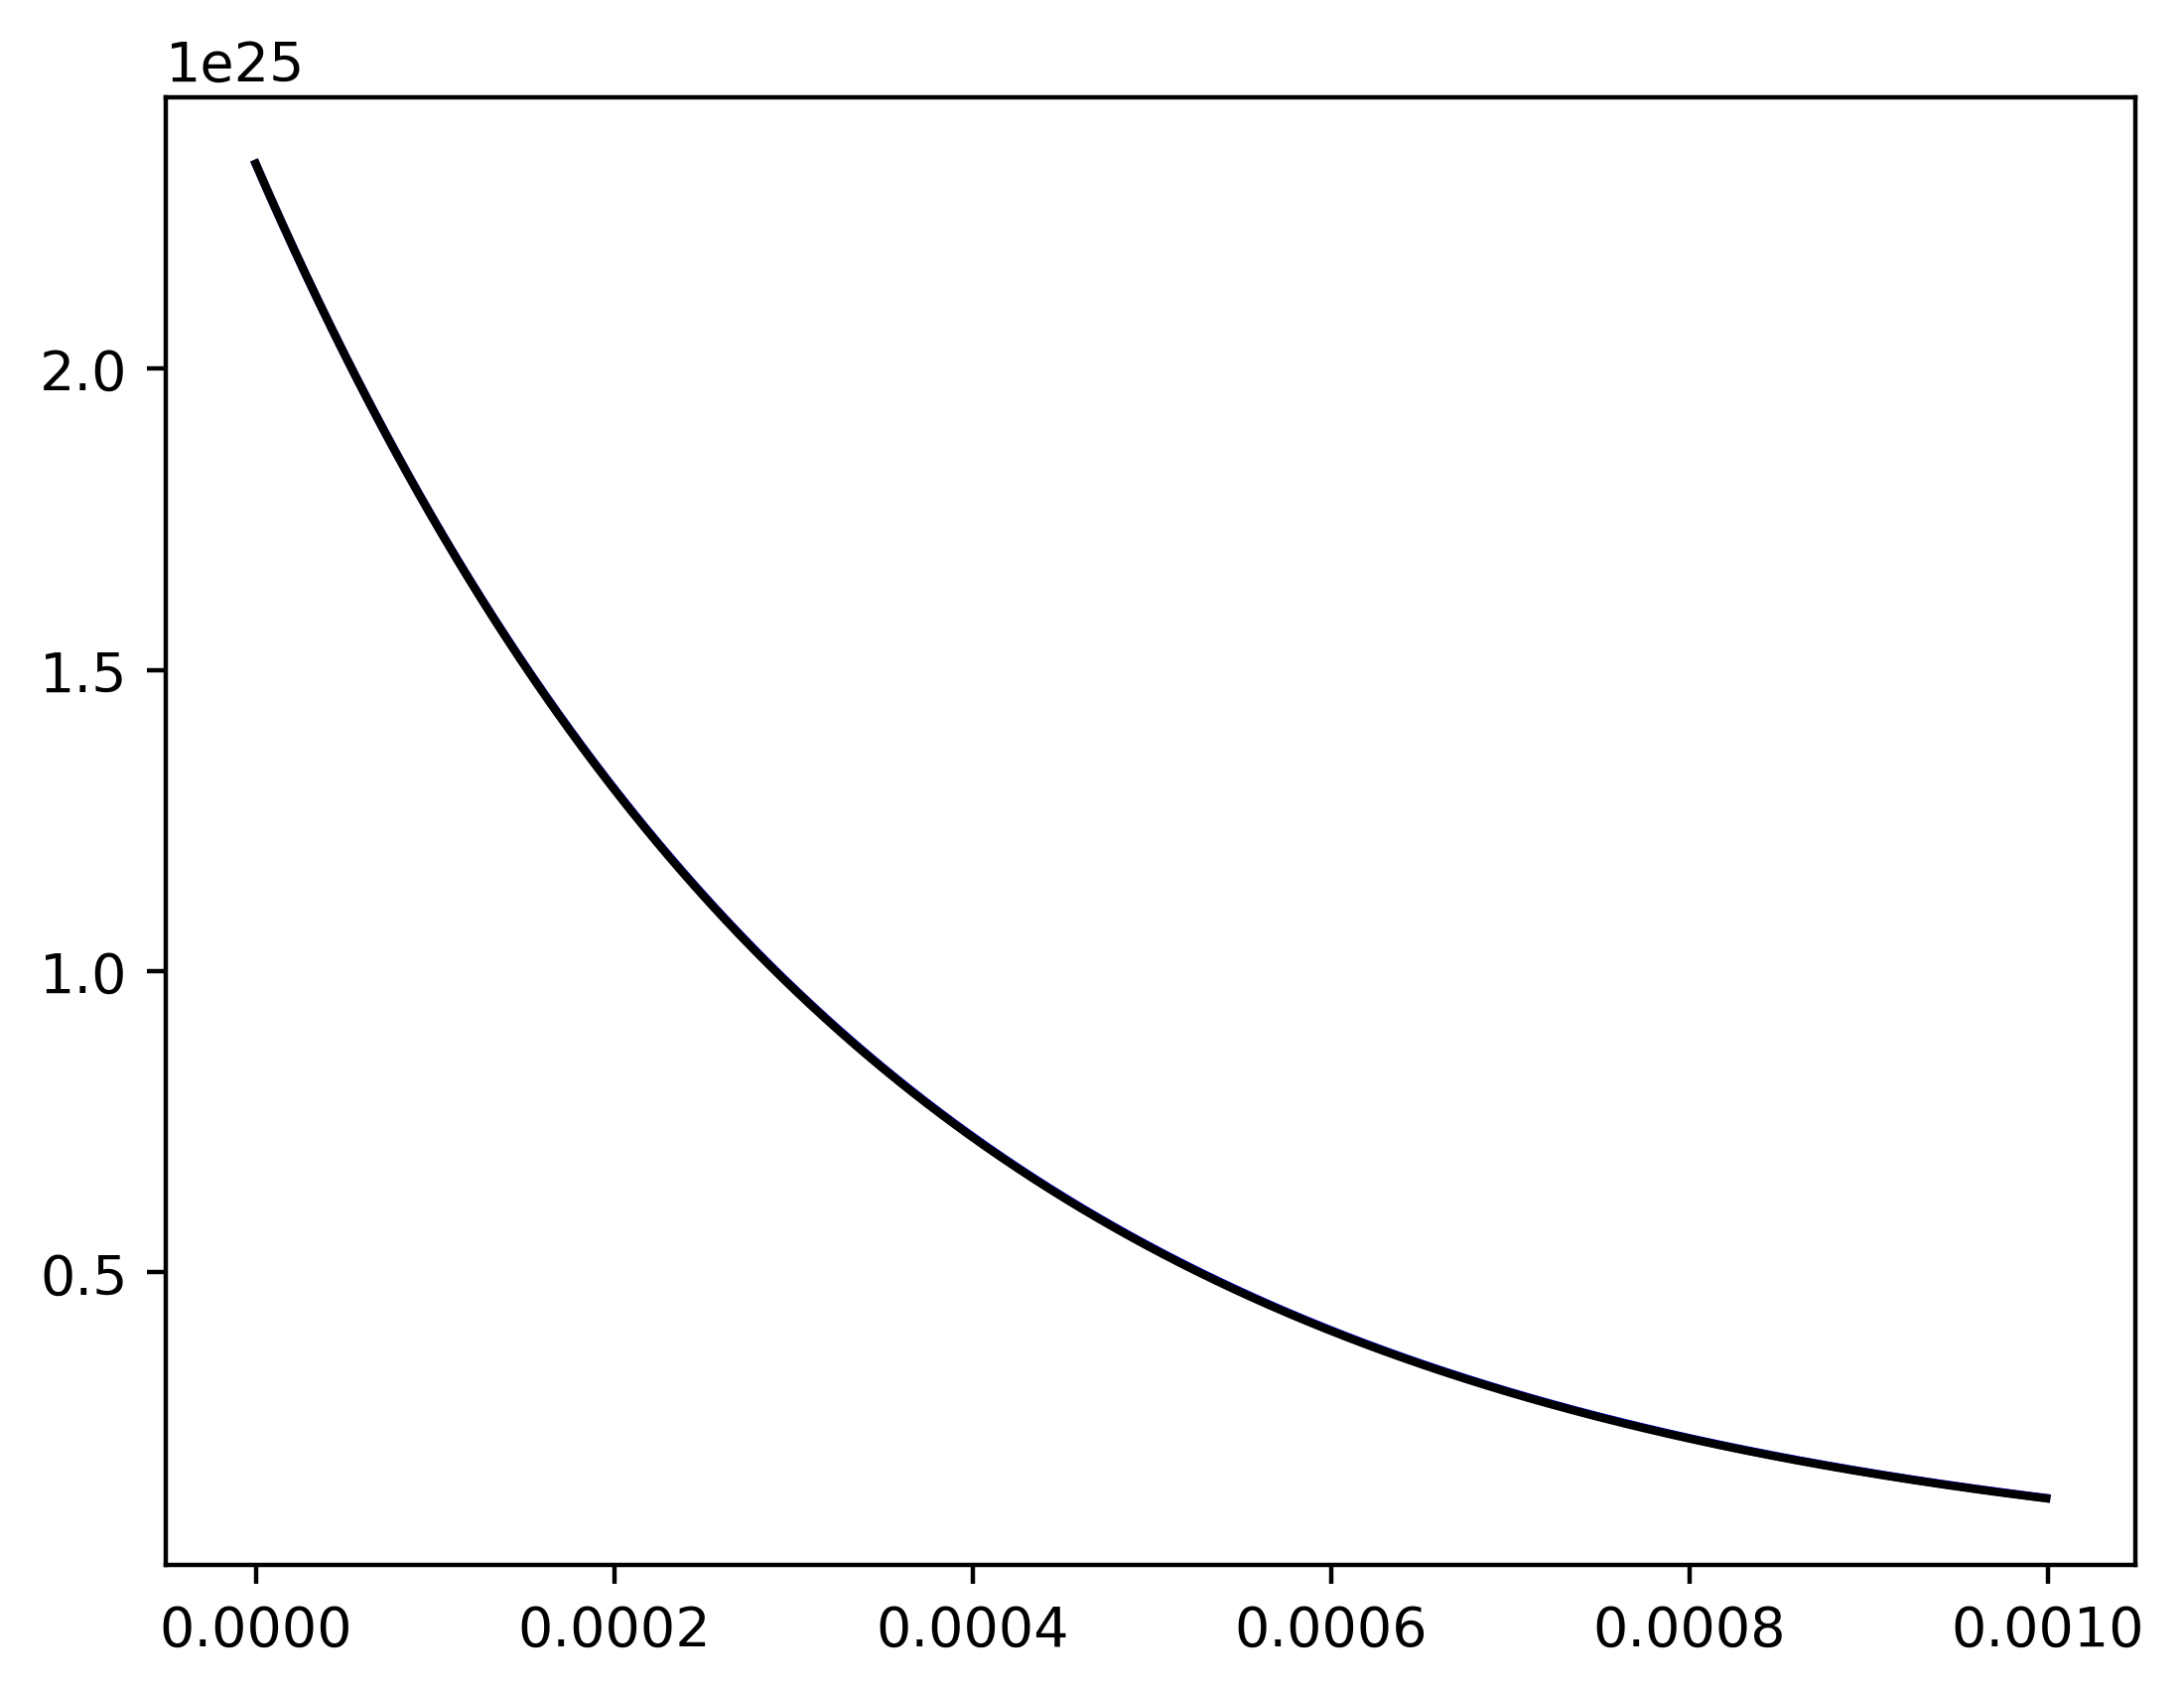

In [7]:
#Pull material data for aluminum
al_mac = xraydb.mu_elam('Al', i_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]
print('Aluminum Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(al_mac))

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]
print('Aluminum Density: {0:.1f} [kg/m^3]'.format(al_dens))

#Configure the test points
e_qty = [10, 50, 100, 500, 1000, 5000] #[-]
e_thick = [0.0001, 0.00002, 0.00001, 0.000002, 0.000001, 2.0e-7] #[m]

#Configure the material properties
al_k = 237 #[W/m*k] - not used for this verification
e_area = 0.1 #[m^2] - not used for this verification
ic_temp = 293.0 #[K] - not used for this verification
al_ab_temp = 1000.0 #[K] - placeholder, not used for this verification
al_c = 897.0 #[J/kg*C] - not used for this verification

#Configure x-ray profile
v_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
v_energy = 13.5e3 #[eV], Average energy of x-rays from event

error = []
for elements in e_qty:
    matl_section = Section()
    matl_section.add_matl(quantity=elements,
                          t_conductivity=al_k,
                          spec_heat=al_c,
                          cs_area=e_area,
                          ic_temp=ic_temp,
                          element_length=e_thickness,
                          ablation_temp=al_ab_temp,
                          rad_abs_coefficient=al_mac,
                          density=al_dens)

#RESUME HERE

#Configure the material properties
elements = 1000 #[-]
e_thickness = 0.000001 #[m]
al_k = 237 #[W/m*k] - not used for this verification
e_area = 0.1 #[m^2] - not used for this verification
ic_temp = 293.0 #[K] - not used for this verification
al_ab_temp = 1000.0 #[K] - placeholder, not used for this verification
al_c = 897.0 #[J/kg*C] - not used for this verification
v_section = Section()
v_section.add_matl(quantity=elements,
                   t_conductivity=al_k,
                   spec_heat=al_c,
                   cs_area=e_area,
                   ic_temp=ic_temp,
                   element_length=e_thickness,
                   ablation_temp=al_ab_temp,
                   rad_abs_coefficient=al_mac,
                   density=al_dens)

#Configure x-ray profile
v_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
v_energy = 13.5e3 #[eV], Average energy of x-rays from event

#Propagate x-rays through material
v_section.prop_xray_energy(v_flux*v_energy)
abs_energy = v_section.get_rem_energy()

#Solve the same problem using the analytical solution
def analytical_soln(I0, mac, density, depth):
    return I0 * math.exp(-mac * density * depth)

#Estimate the error by integrating the absolute value of the difference between the two solutions at
#each point.
abs_error = 0
analytical_values = []
depth_list = v_section.get_node_depths()
for i in range(0, elements):
    analytical_value = analytical_soln(v_flux*v_energy, al_mac, al_dens, depth_list[i])
    analytical_values.append(analytical_value)
    abs_error += abs(analytical_value - abs_energy[i]) * e_thickness
print("Absolute error between analytical solution and numerical solution: {0:.2f} [eV]".format(abs_error))
    
#Visualize the results
fig, ax = plt.subplots()
ax.plot(depth_list, analytical_values, 'b')
ax.plot(depth_list, abs_energy, 'k')
plt.show()

### Testing Section

1000


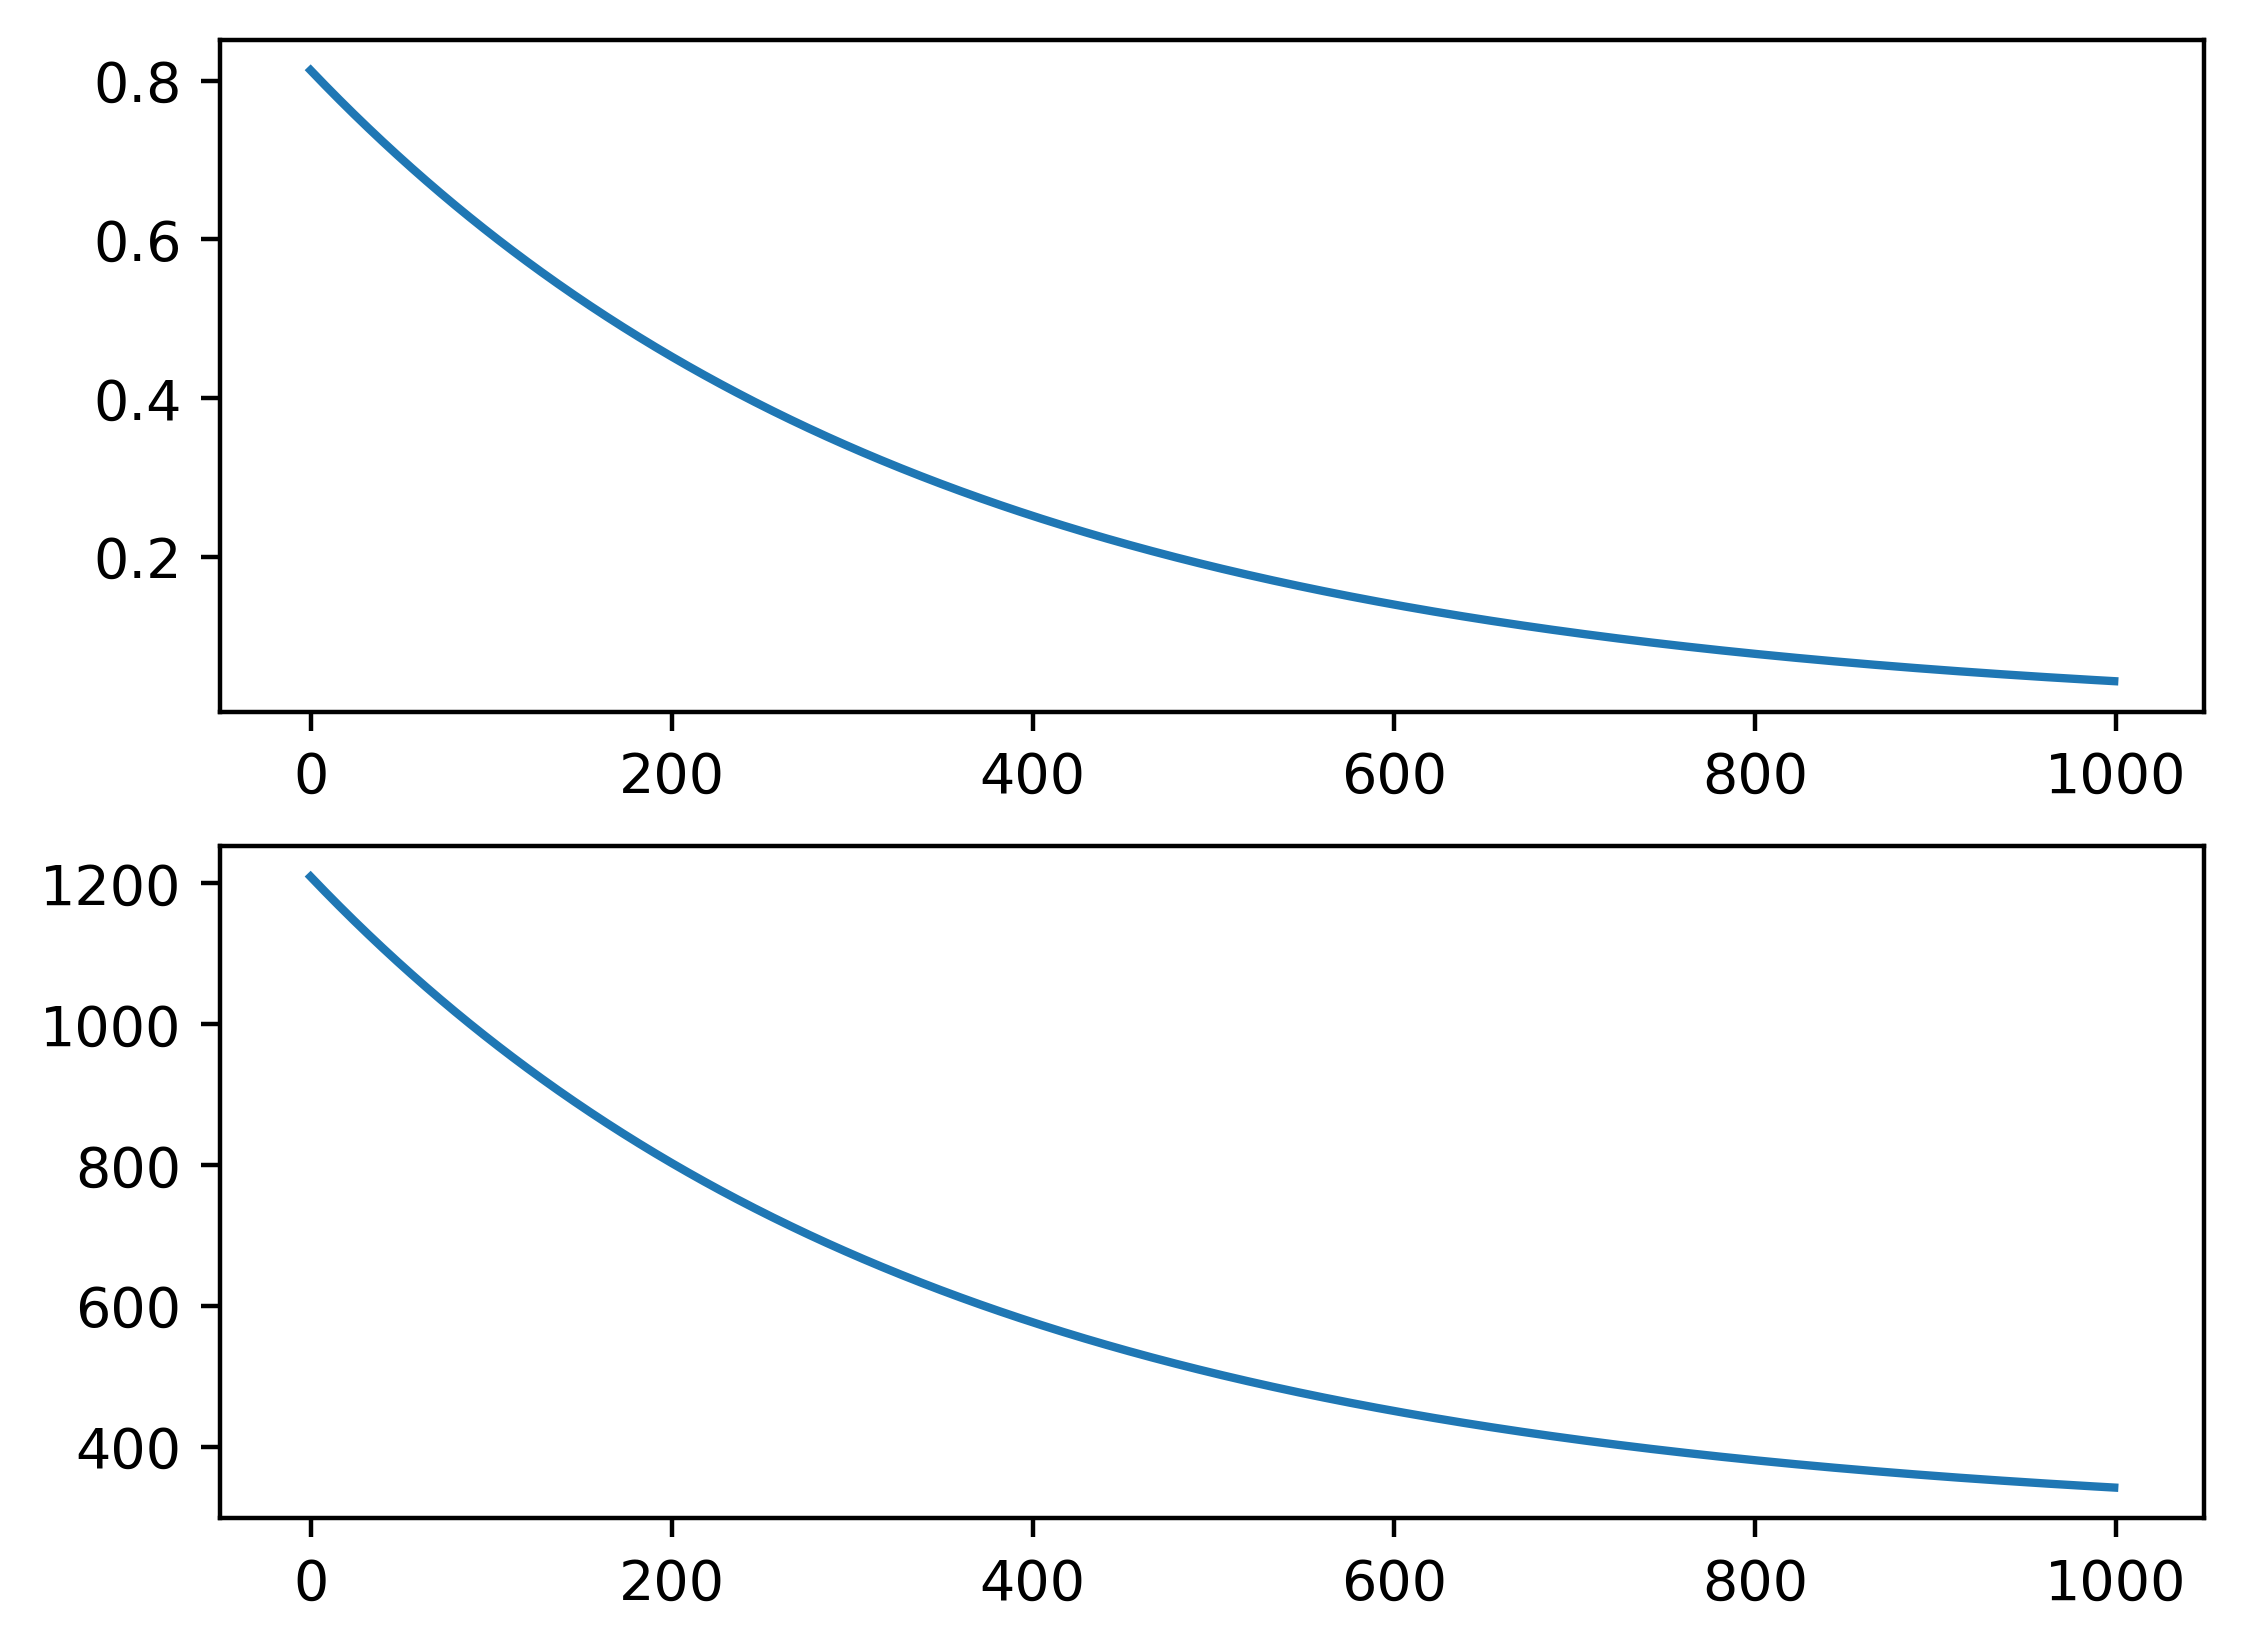

In [6]:
test_xray_energy = i_flux
t_conductivity = 1.0
specific_heat = 887
cs_area = 1.0
ic_temp = 293.0
ablation_temp = 100.0

test_section = Section()
test_section.add_matl(1000,
                      t_conductivity,
                      specific_heat,
                      cs_area,
                      ic_temp,
                      0.000001,
                      ablation_temp,
                      al_mac,
                      al_dens)

test_section.prop_xray_energy(test_xray_energy)
a_energy = test_section.get_absorbed_energy()
temp = test_section.get_temperatures()

fig, ax = plt.subplots(2)
x_points = range(0, len(a_energy))
ax[0].plot(x_points, a_energy)
ax[1].plot(x_points, temp)
plt.show()